<a href="https://colab.research.google.com/github/Sridevi-SV/customer-churn/blob/main/Customer_Churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score
)

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression


In [75]:
df = pd.read_excel("Telco_customer_churn.xlsx")
print(df.shape)
df.head()


(7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [76]:

drop_cols = [
    'CustomerID', 'Count', 'Country', 'State', 'City',
    'Zip Code', 'Lat Long', 'Latitude', 'Longitude',
    'Churn Reason', 'Churn Score', 'CLTV','Churn Label'
]

df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

print("Shape after dropping columns:", df.shape)


Shape after dropping columns: (7043, 20)


In [77]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].median())

df['Churn Value'] = df['Churn Value'].astype(int)


In [78]:
binary_cols = [
    'Partner', 'Dependents', 'Phone Service', 'Paperless Billing'
]

service_cols = [
    'Multiple Lines', 'Online Security', 'Online Backup',
    'Device Protection', 'Tech Support', 'Streaming TV',
    'Streaming Movies'
]

# Simple Yes/No columns
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# Service columns: normalize "No internet service" / "No phone service"
for col in service_cols:
    if col in df.columns:
        df[col] = df[col].replace(
            {'No internet service': 'No', 'No phone service': 'No'}
        )
        df[col] = df[col].map({'Yes': 1, 'No': 0})


In [79]:
leak_cols = ['Churn Reason', 'Churn Score', 'CLTV']
df.drop(columns=[c for c in leak_cols if c in df.columns], inplace=True)


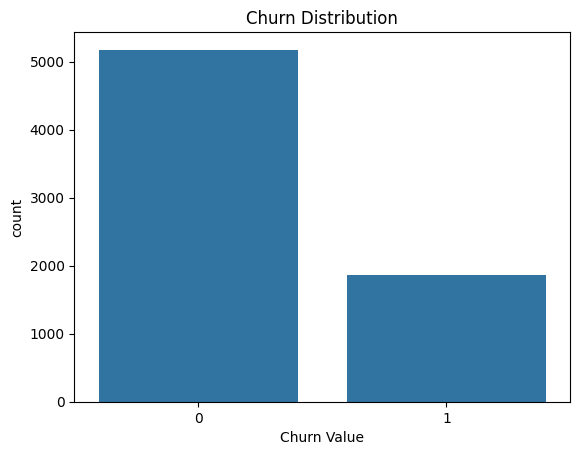

In [80]:
sns.countplot(x='Churn Value', data=df)
plt.title("Churn Distribution")
plt.show()


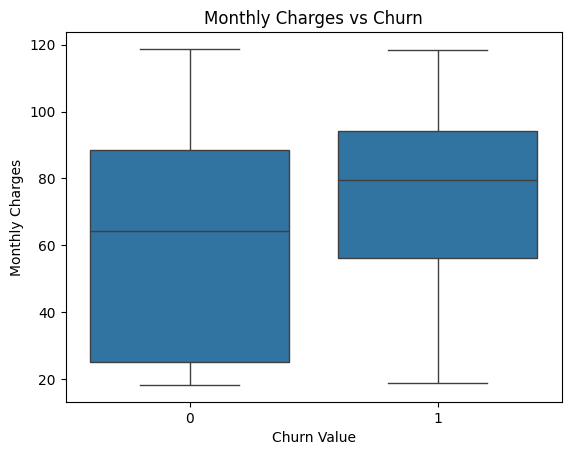

In [81]:
sns.boxplot(x='Churn Value', y='Monthly Charges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()


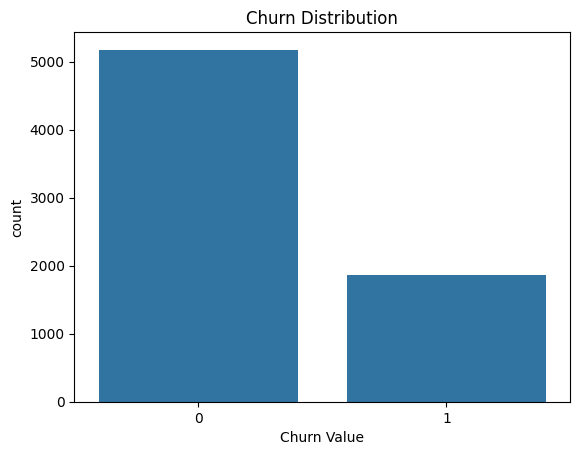

In [82]:
sns.countplot(x='Churn Value', data=df)
plt.title("Churn Distribution")
plt.show()


In [83]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
print(cat_cols)


['Gender', 'Senior Citizen', 'Internet Service', 'Contract', 'Payment Method']


In [84]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)



In [85]:
X = df_encoded.drop('Churn Value', axis=1)
y = df_encoded['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [86]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [87]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8062455642299503
ROC-AUC: 0.849187527448397
Confusion Matrix:
 [[920 115]
 [158 216]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.58      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [88]:
# ================================
# Threshold tuning to improve recall
# ================================

threshold = 0.4
y_pred_custom = (y_proba >= threshold).astype(int)

print(f"Metrics at threshold = {threshold}")
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))


Metrics at threshold = 0.4
[[854 181]
 [124 250]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1035
           1       0.58      0.67      0.62       374

    accuracy                           0.78      1409
   macro avg       0.73      0.75      0.73      1409
weighted avg       0.80      0.78      0.79      1409



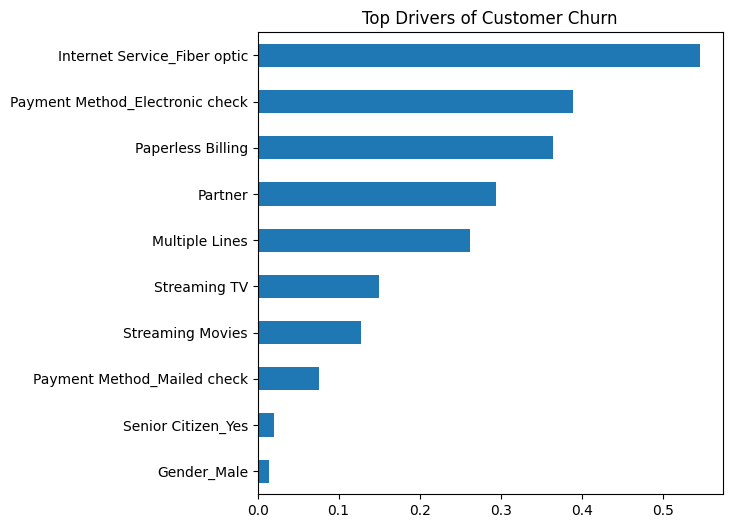

,0
Internet Service_Fiber optic,0.546550
Payment Method_Electronic check,0.389214
Paperless Billing,0.364528
Partner,0.294506
Multiple Lines,0.261690
Streaming TV,0.149988
Streaming Movies,0.127996
Payment Method_Mailed check,0.076054
Senior Citizen_Yes,0.020232
Gender_Male,0.014531


In [89]:
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.Series(
    model.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(6,6))
importance.head(10).plot(kind='barh')
plt.title("Top Drivers of Customer Churn")
plt.gca().invert_yaxis()
plt.show()

importance.head(10)
